In [1]:
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib

import sys
sys.path.insert(0, '../../')
import DLDMD as dl
import LossDLDMD as lf
import Data as dat
import Training as tr

%matplotlib inline

In [2]:
def cpinv(A):
    R = tf.math.real(A)
    C = tf.math.imag(A)
    r0 = tf.linalg.pinv(R) @ C
    y11 = tf.linalg.pinv(C @ r0 + R)
    y10 = -r0 @ y11
    return tf.cast(tf.complex(y11, y10), dtype=A.dtype)

def dmd(x, num_pred, t_final, delta_t):
    x = tf.transpose(x, perm=[0, 2, 1])
    x_m = x[:, :, :-1]
    x_p = x[:, :, 1:]
    S, U, Vh = tf.linalg.svd(x_m, compute_uv=True, full_matrices=False)
    S = tf.linalg.diag(S)
    r = S.shape[-1]
    Si = tf.linalg.pinv(S)
    U = U[:, :, :r]
    Ut = tf.transpose(U, conjugate=True, perm=[0, 2, 1])
    Vh = Vh[:, :, :r]
    A = Ut @ (x_p @ (Vh @ Si))
    Lam, W = tf.linalg.eig(A)
    Phi = tf.cast(((x_p @ Vh) @ Si), dtype=tf.complex128) @ W
    Phi_inv = cpinv(Phi)
    y0 = tf.cast(x_m[:, :, 0], dtype=tf.complex128)
    b = tf.linalg.matvec(Phi_inv, y0)
    Psi = tf.TensorArray(tf.complex128, size=num_pred)
    tpred = tf.cast(tf.linspace(0, t_final, num_pred), dtype=tf.complex128)
    for ii, tstep in enumerate(tpred):
        Psi = Psi.write(ii, tf.math.multiply(tf.math.pow(Lam, tstep / delta_t), b))
    Psi = tf.transpose(Psi.stack(), perm=[1, 2, 0])
    x_adv = Phi @ Psi
    x_adv = tf.transpose(x_adv, perm=[0, 2, 1])
    x_adv_real = tf.math.real(x_adv)
    x_adv_imag = tf.math.imag(x_adv)
    return x_adv_real, x_adv_imag, Lam, Phi, b

# Setup

In [3]:
# Figure parameters
plot_save_path = './analysis_results/'
font = {'family': 'DejaVu Sans', 'size': 18}
matplotlib.rc('font', **font)
fontsize = 18
figsize = (15, 10)
dpisave = 300

# Initialize the compute device
DEVICE = '/GPU:0'
GPUS = tf.config.experimental.list_physical_devices('GPU')
if GPUS:
    try:
        for gpu in GPUS:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
else:
    DEVICE = '/CPU:0'
    
tf.keras.backend.set_floatx('float64')  # !! Set precision for the entire model here
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))
print("Num GPUs available: {}".format(len(GPUS)))
print("Training at precision: {}".format(tf.keras.backend.floatx()))
print("Training on device: {}".format(DEVICE))

TensorFlow version: 2.5.0
Eager execution: True
Num GPUs available: 2
Training at precision: float64
Training on device: /GPU:0


# Load model and data

In [9]:
# SET THIS PATH (w/o file extension). Both '.pkl' and '.h5' files should have same name
model_path = './trained_models/van_der_pol_2021-05-09-2217/epoch_100_loss_-0.802'

# Load the hyper parameters
hyp_params = pickle.load(open(model_path + '.pkl', 'rb'))

# Set Tensorflow backend precision
tf.keras.backend.set_floatx(hyp_params['precision'])
print("Using precision: {}\n".format(tf.keras.backend.floatx()))

# Generate data
from scipy.integrate import solve_ivp
nic = 1000
def vdp(t, x):
    return [x[1], mu * (1 - x[0] ** 2) * x[1] - x[0]]
mu = hyp_params['mu']
icx = np.random.uniform(-2, 2, nic)
icy = np.random.uniform(-2, 2, nic)
tspan = np.array([0, hyp_params['time_final']])
dts = np.arange(0, hyp_params['time_final'], hyp_params['delta_t'])
X = np.zeros(shape=(nic, 2, hyp_params['num_time_steps']))
for ii, ic in enumerate(zip(icx, icy)):
    tmp = solve_ivp(vdp, t_span=tspan, y0=ic, method='RK45', t_eval=dts)
    X[ii, :, :] = tmp.y
test_data = tf.transpose(X, perm=[0, 2, 1])
test_data = tf.cast(test_data, dtype=hyp_params['precision'])
print("Test data shape: {}".format(test_data.shape))

Using precision: float64

Test data shape: (1000, 200, 2)


In [10]:
# Fix hyper parameters for running the model on test data
hyp_params['pretrain'] = False
hyp_params['batch_size'] = test_data.shape[0]
hyp_params['num_time_steps'] = test_data.shape[1]
hyp_params['latent_dim'] = test_data.shape[2]
hyp_params['phys_dim'] = test_data.shape[2]

# Load the trained DLDMD model weights
model = dl.DLDMD(hyp_params)
model.num_pred_steps = model.num_time_steps
model.time_final = int(model.num_time_steps*model.delta_t)
model(test_data)
model.load_weights(model_path + '.h5')

# Initialize the loss function
loss = lf.LossDLDMD(hyp_params)
print("Number of prediction steps: ", model.num_pred_steps)

Number of prediction steps:  200


# Run the DLDMD model

In [11]:
with tf.device(DEVICE):
    [y, x_ae, x_adv, y_adv_real, y_adv_imag, weights, Lam, Phi, b] = model(test_data, training=False)
    losses = loss([y, x_ae, x_adv, y_adv_real, y_adv_imag, weights, Lam, Phi, b], test_data)
    y_adv = y_adv_real

print("Loss: {loss:2.7f}".format(loss=losses.numpy()))
print("Log10 Loss: {loss:2.7f}".format(loss=np.log10(losses.numpy())))

Loss: 3588.4394531
Log10 Loss: 3.5549056


# Run standard DMD

In [12]:
# Standard DMD on the unencoded data
[x_dmd_r, x_dmd_i, Lam_dmd, Phi_dmd, b_dmd] = dmd(test_data, num_pred=test_data.shape[1], t_final=30, delta_t=0.02)
x_dmd = x_dmd_r

# Visualize results

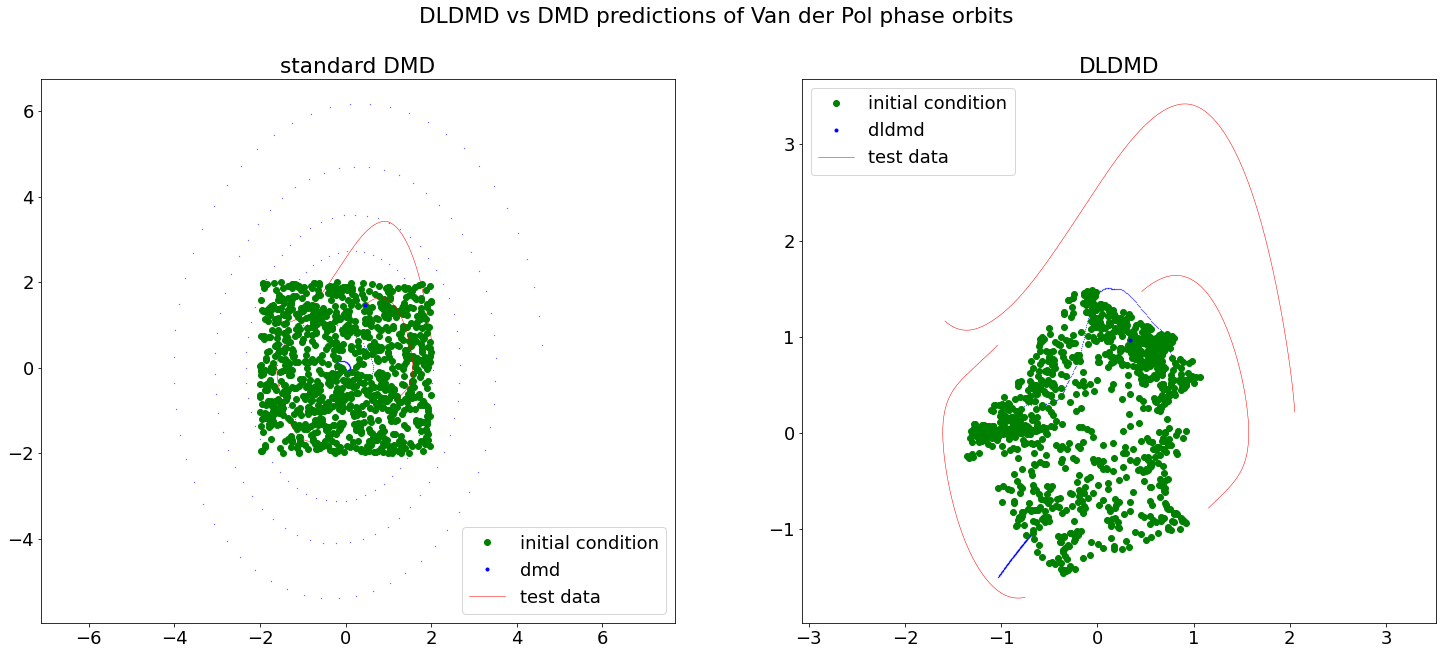

In [17]:
fig = plt.figure(3141, figsize=(25,10))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)
for ii in range(0, test_data.shape[0], 100):
    ax1.plot(test_data[ii, :, 0], test_data[ii, :, 1], 'r-', lw=0.5)
    ax1.plot(x_dmd[ii, :, 0], x_dmd[ii, :, 1], 'b.', ms=0.5)
    ax2.plot(test_data[ii, :, 0], test_data[ii, :, 1], 'r-', lw=0.5)
    ax2.plot(x_adv[ii, :, 0], x_adv[ii, :, 1], 'b.', ms=0.5)
ax1.plot(x_dmd[:, 0, 0], x_dmd[:, 0, 1], 'go', label='initial condition')
ax2.plot(x_adv[:, 0, 0], x_adv[:, 0, 1], 'go', label='initial condition')
ax1.plot(x_dmd[0, 0, 0], x_dmd[0, 0, 1], 'b.', label='dmd')
ax2.plot(x_adv[0, 0, 0], x_adv[0, 0, 1], 'b.', label='dldmd')
ax1.plot(test_data[0, :, 0], test_data[0, :, 1], 'r-', lw=0.5, label='test data')
ax2.plot(test_data[0, :, 0], test_data[0, :, 1], 'r-', lw=0.5, label='test data')
ax1.legend()
ax2.legend()
ax1.axis('equal')
ax2.axis('equal')
ax1.set_title('standard DMD')
ax2.set_title('DLDMD')
plt.suptitle("DLDMD vs DMD predictions of Van Der Pol phase orbits")
plt.show()

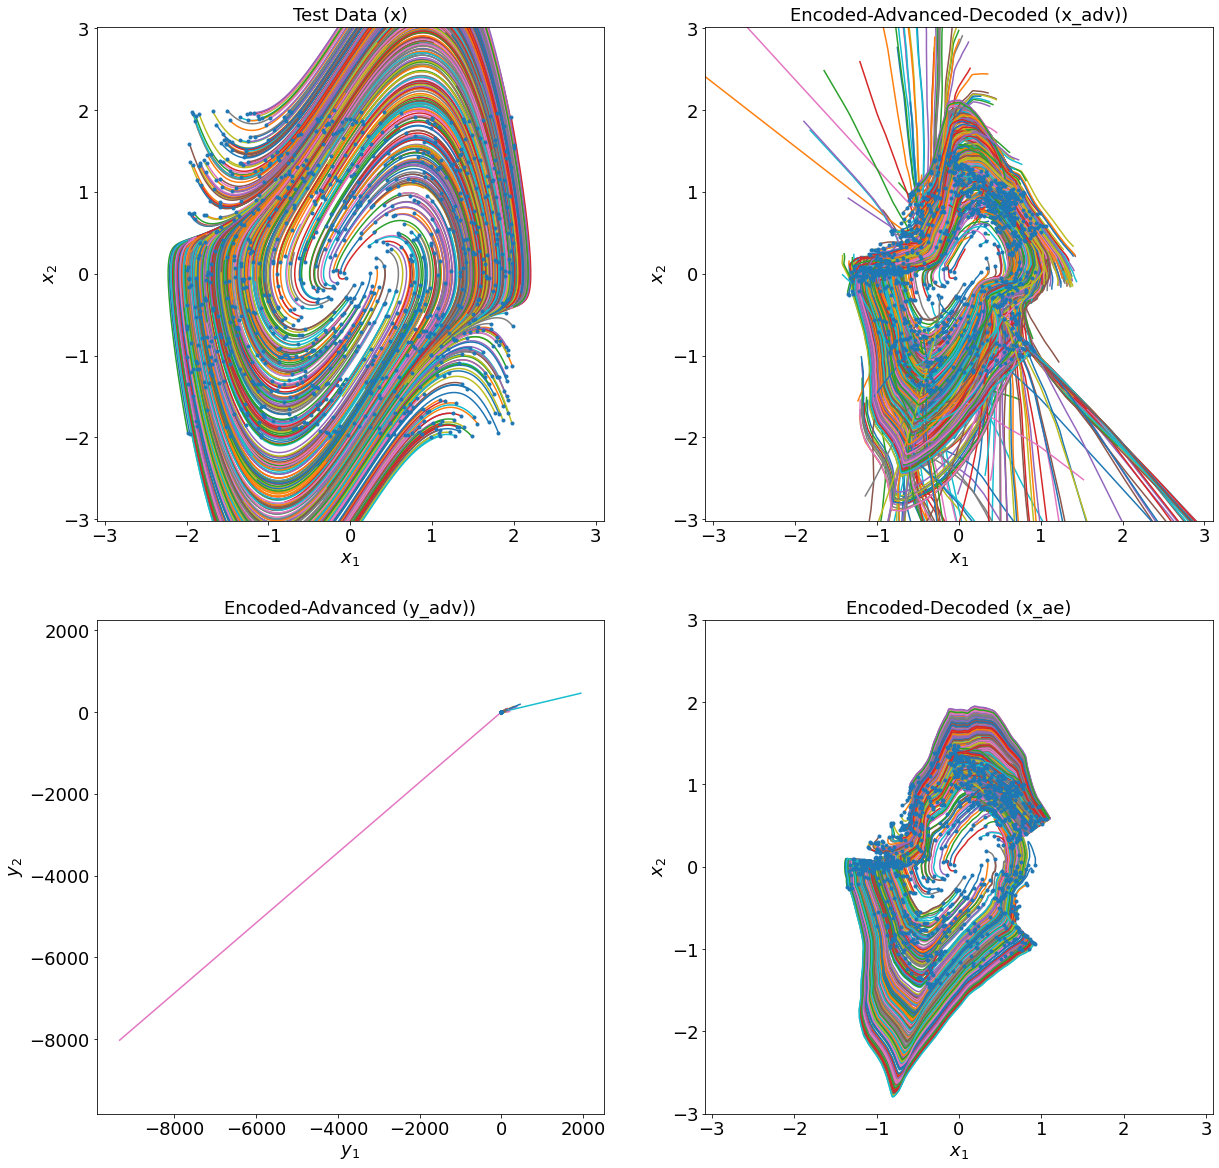

In [18]:
fig = plt.figure(1, figsize=(20,20))
ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 2)
ax3 = plt.subplot(2, 2, 3)
ax4 = plt.subplot(2, 2, 4)
for ii in range(test_data.shape[0]):
    ax1.plot(test_data[ii, :, 0], test_data[ii, :, 1], '-')
    ax2.plot(x_adv[ii, :, 0], x_adv[ii, :, 1], '-')
    ax3.plot(y_adv[ii, :, 0], y_adv[ii, :, 1], '-')
    ax4.plot(x_ae[ii, :, 0], x_ae[ii, :, 1], '-')
ax1.plot(test_data[:, 0, 0], test_data[:, 0, 1], '.')
ax2.plot(x_adv[:, 0, 0], x_adv[:, 0, 1], '.')
ax3.plot(y_adv[:, 0, 0], y_adv[:, 0, 1], '.')
ax4.plot(x_ae[:, 0, 0], x_ae[:, 0, 1], '.')
ax1.axis('equal')
ax1.set_xlim([-3.1, 3.1])
ax1.set_ylim([-3.0, 3.0])
ax1.set_xlabel("$x_1$", fontsize=fontsize)
ax1.set_ylabel("$x_2$", fontsize=fontsize)
ax1.set_title("Test Data (x)", fontsize=fontsize)
ax2.axis('equal')
ax2.set_xlim([-3.1, 3.1])
ax2.set_ylim([-3.0, 3.0])
ax2.set_xlabel("$x_1$", fontsize=fontsize)
ax2.set_ylabel("$x_2$", fontsize=fontsize)
ax2.set_title("Encoded-Advanced-Decoded (x_adv))", fontsize=fontsize)
ax3.axis('equal')
ax3.set_xlabel("$y_1$", fontsize=fontsize)
ax3.set_ylabel("$y_2$", fontsize=fontsize)
ax3.set_title("Encoded-Advanced (y_adv))", fontsize=fontsize)
ax4.axis('equal')
ax4.set_xlim([-3.1, 3.1])
ax4.set_ylim([-3.0, 3.0])
ax4.set_xlabel("$x_1$", fontsize=fontsize)
ax4.set_ylabel("$x_2$", fontsize=fontsize)
ax4.set_title("Encoded-Decoded (x_ae)", fontsize=fontsize)

plt.show()

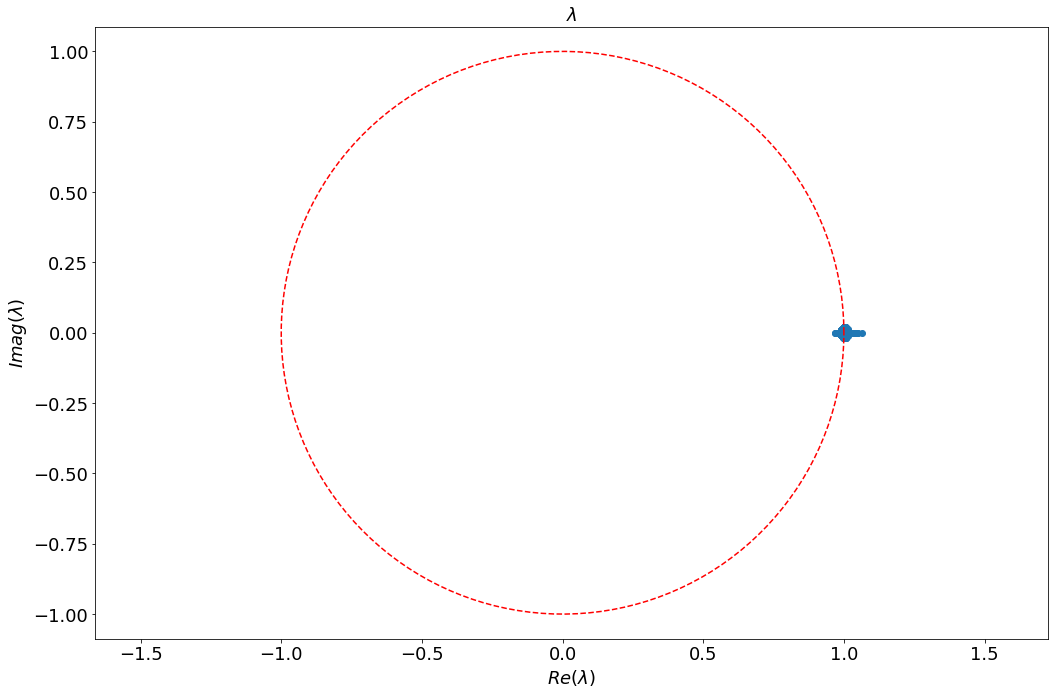

In [19]:
# Eigenvalues
angle = np.linspace(0, 2*np.pi, 150)
radius = 1.0
x = radius * np.cos(angle)
y = radius * np.sin(angle)
fig = plt.figure(666, figsize=figsize)
ax1 = plt.subplot(1, 1, 1)
s1 = ax1.scatter(np.real(Lam[:]), np.imag(Lam[:]))
ax1.plot(x, y, 'r--')
ax1.axis('equal')
ax1.set_xlabel("$Re(\lambda)$", fontsize=fontsize)
ax1.set_ylabel("$Imag(\lambda)$", fontsize=fontsize)
ax1.set_title("$\lambda$", fontsize=fontsize)
plt.tight_layout()
plt.show()